In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

esa_adb_challenge_path = kagglehub.competition_download('esa-adb-challenge')

print('Data source import complete.')


100%|██████████| 282M/282M [00:01<00:00, 208MB/s]

Extracting files...


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
df = pd.read_parquet(f"{esa_adb_challenge_path}/train.parquet")

df.head()

,id,channel_1,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15,channel_16,channel_17,...,telecommand_351,telecommand_352,telecommand_353,telecommand_354,telecommand_36,telecommand_376,telecommand_38,telecommand_39,telecommand_40,is_anomaly
0,0,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
print(f"The dataset has {df.shape[0]:,} records")

The dataset has 14,728,321 records


In [7]:
targets_df = pd.read_csv(f"{esa_adb_challenge_path}/target_channels.csv")
targets_df.shape

(58, 1)

In [8]:
targets_df.head()

,target_channels
0,channel_12
1,channel_13
2,channel_14
3,channel_15
4,channel_16


Train dataset shape: (14728321, 89)
   id  channel_1  channel_10  channel_11  channel_12  channel_13  channel_14  \
0   0    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
1   1    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
2   2    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
3   3    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
4   4    0.13791         0.0         0.0    0.317175    0.371764    0.297205   

   channel_15  channel_16  channel_17  ...  telecommand_351  telecommand_352  \
0    0.130113    0.766769    0.349474  ...              0.0              0.0   
1    0.130113    0.766769    0.349474  ...              0.0              0.0   
2    0.130113    0.766769    0.349474  ...              0.0              0.0   
3    0.130113    0.766769    0.349474  ...              0.0              0.0   
4    0.130113    0.766769    0.349474  ...              0.0              0.0   

  

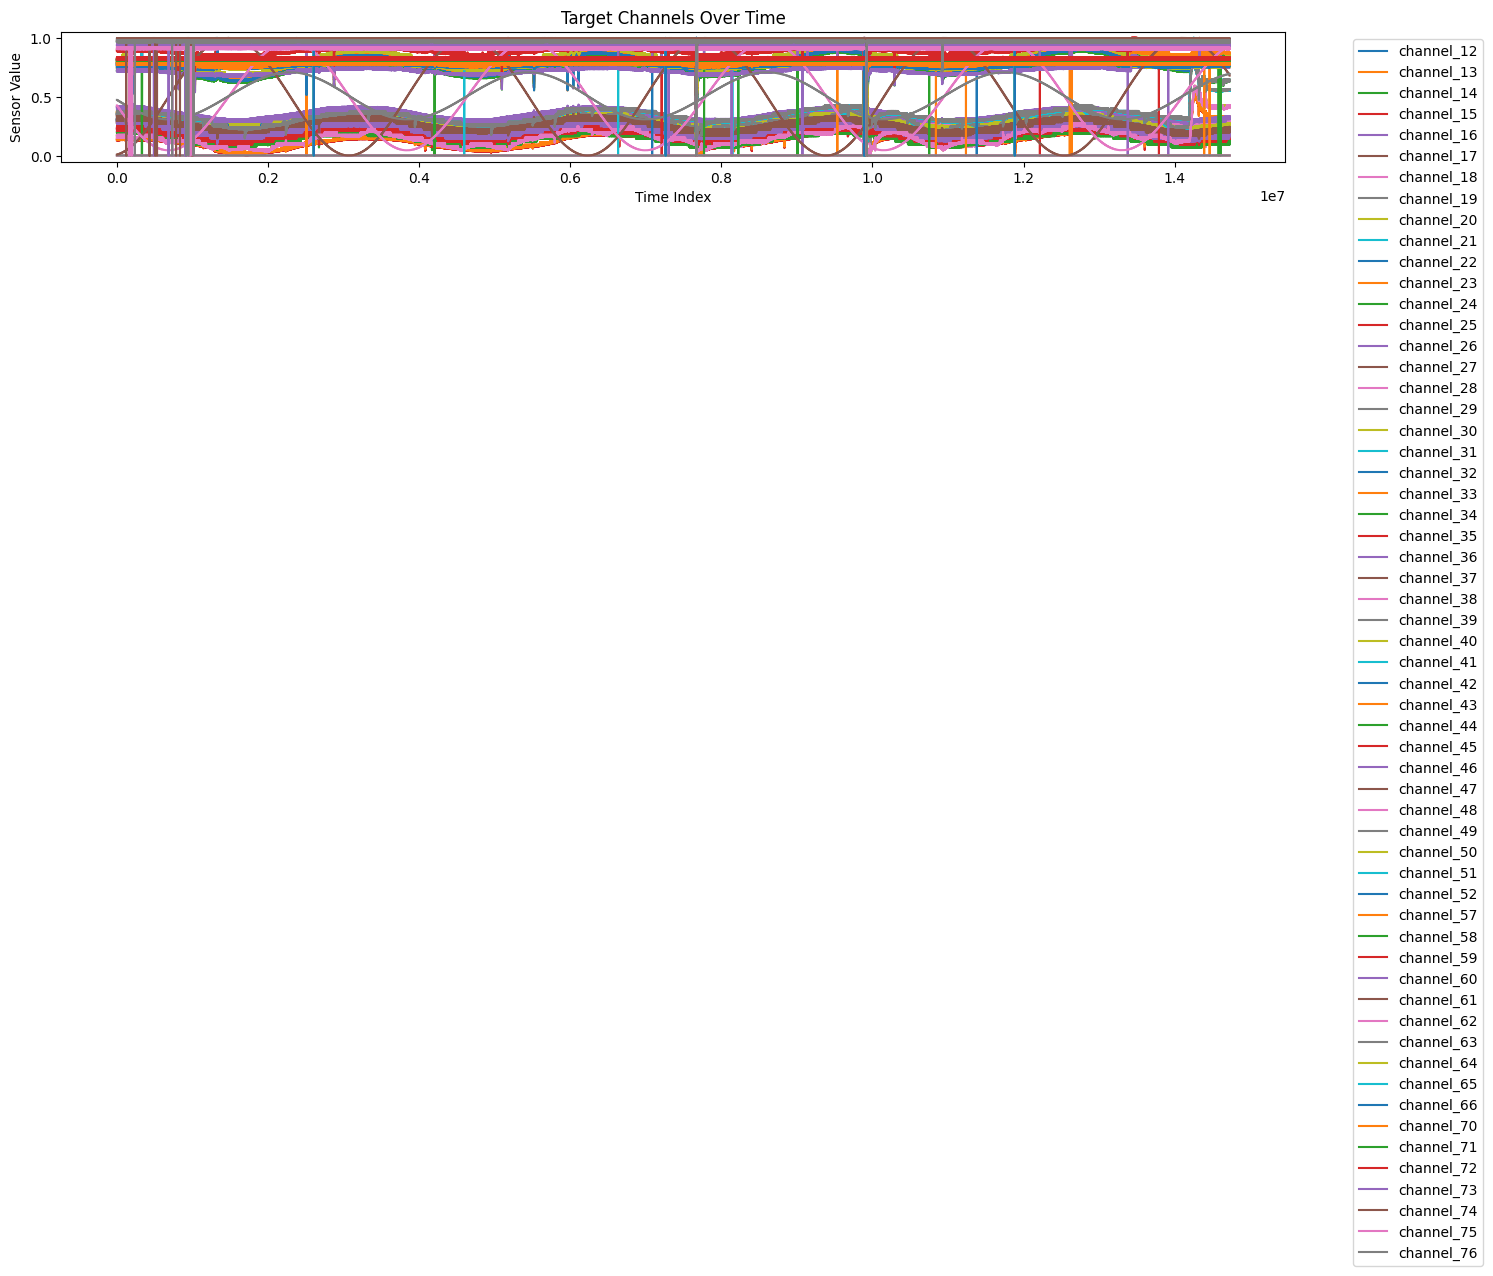

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the target channels list
targets_df = pd.read_csv(f"{esa_adb_challenge_path}/target_channels.csv")
target_channels = targets_df['target_channels'].tolist()

# Read the tr?ain dataset
df_train = pd.read_parquet(f"{esa_adb_challenge_path}/train.parquet")

# Display basic info
print("Train dataset shape:", df_train.shape)
print(df_train.head())

# Plot all target channels over time
plt.figure(figsize=(15, 8))
for channel in target_channels:
    if channel in df_train.columns:
        plt.plot(df_train['id'], df_train[channel], label=channel)

plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.title("Target Channels Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# INSTALLING LIBRARIES

In [10]:
# Install required packages
!pip install pgmpy tqdm -q

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
import networkx as nx

# Try importing from pgmpy, handle if not available
try:
    from pgmpy.estimators import PC
    from pgmpy.estimators.CITests import chi_square
except ImportError:
    print("pgmpy not available, installing now...")
    !pip install pgmpy -q
    from pgmpy.estimators import PC
    from pgmpy.estimators.CITests import chi_square

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 14.1 MB/s eta 0:00:00


# DATA LOADING

In [11]:
# Data Loading and Preparation Functions

def load_data(file_path, n_samples=None):
    """
    Load spacecraft telemetry data

    Args:
        file_path: Path to the parquet file
        n_samples: Number of samples to load (None for all)

    Returns:
        DataFrame with telemetry data
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_parquet(file_path)

    if n_samples is not None:
        df = df.iloc[:n_samples]

    print(f"Loaded data with shape: {df.shape}")
    return df

def prepare_data(df, target_channels_path):
    """
    Prepare data for analysis by identifying channel types

    Args:
        df: DataFrame with telemetry data
        target_channels_path: Path to target channels list

    Returns:
        tuple of (dataframe, target_channels, telecommand_channels, auxiliary_channels)
    """
    # Load target channels
    targets_df = pd.read_csv(target_channels_path)
    target_channels = targets_df['target_channels'].tolist()

    # Identify telecommand channels
    telecommand_cols = [col for col in df.columns if col.startswith('telecommand_')]

    # Identify auxiliary channels (non-target, non-telecommand)
    all_cols = set(df.columns)
    auxiliary_cols = list(all_cols - set(target_channels) - set(telecommand_cols) - {'id', 'is_anomaly'})

    print(f"Target channels: {len(target_channels)}")
    print(f"Telecommand channels: {len(telecommand_cols)}")
    print(f"Auxiliary channels: {len(auxiliary_cols)}")

    return df, target_channels, telecommand_cols, auxiliary_cols


## CASUAL STRUCTURE LEARNING

In [12]:
# Causal Structure Learning Functions

def learn_causal_structure(df, target_channels, telecommand_cols, significance_level=0.05, sample_size=10000):
    """
    Learn causal structure using PC algorithm on a subset of channels

    Args:
        df: DataFrame with telemetry data
        target_channels: List of target channel names
        telecommand_cols: List of telecommand channel names
        significance_level: Significance level for conditional independence tests
        sample_size: Number of samples to use for structure learning (to keep it tractable)

    Returns:
        NetworkX graph representing causal structure
    """
    print("Learning causal structure...")

    # Sample data to make structure learning more tractable
    if len(df) > sample_size:
        sample_df = df.sample(sample_size, random_state=42)
    else:
        sample_df = df

    # Start with recommended subset (channels 41-46) as mentioned in the papers
    subset_channels = [col for col in target_channels if col.split('_')[1] in
                      ['41', '42', '43', '44', '45', '46']]

    if not subset_channels:
        # If recommended channels not available, take first 6 target channels
        subset_channels = target_channels[:6]

    # Include telecommands as intervention variables
    variables = subset_channels + telecommand_cols

    if not variables:
        print("No variables available for causal discovery")
        return nx.DiGraph()

    # Discretize data for structure learning
    discretized_data = sample_df[variables].copy()
    for col in variables:
        # Handle constant columns
        if sample_df[col].nunique() <= 1:
            discretized_data[col] = 0
        else:
            try:
                discretized_data[col] = pd.qcut(sample_df[col], 3, labels=False, duplicates='drop')
            except:
                # Fallback for problematic distributions
                discretized_data[col] = pd.cut(sample_df[col], 3, labels=False)

    # Learn structure using PC algorithm
    try:
        pc = PC(data=discretized_data)
        skeleton = pc.estimate(significance_level=significance_level, variant="stable")
        print(f"Learned structure with {len(skeleton.edges())} edges")
        return skeleton
    except Exception as e:
        print(f"Error in causal structure learning: {e}")
        return nx.DiGraph()

def add_causal_features(df, causal_structure, lag=1):
    """
    Add causal features based on the learned structure

    Args:
        df: DataFrame with telemetry data
        causal_structure: NetworkX graph with causal structure
        lag: Lag for causal features

    Returns:
        DataFrame with added causal features
    """
    if not causal_structure.edges():
        return df

    # Create a copy to avoid modifying the original
    enhanced_df = df.copy()

    # Add lagged features based on causal parents
    for node in causal_structure.nodes():
        parents = list(causal_structure.predecessors(node))
        for parent in parents:
            feature_name = f"{parent}_causes_{node}"
            try:
                enhanced_df[feature_name] = df[parent].shift(lag)
                # Fill NaN with appropriate values (first rows)
                enhanced_df[feature_name].fillna(df[parent].iloc[0], inplace=True)
            except Exception as e:
                print(f"Error adding causal feature {feature_name}: {e}")

    return enhanced_df

def visualize_causal_graph(causal_structure):
    """
    Visualize the learned causal structure as a graph

    Args:
        causal_structure: NetworkX graph with causal structure
    """
    if not causal_structure.edges():
        print("No edges in causal structure to visualize")
        return

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(causal_structure, seed=42)

    # Draw nodes and edges
    nx.draw_networkx(
        causal_structure,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=500,
        font_size=10,
        arrows=True,
        arrowsize=15
    )

    plt.title('Causal Structure of Spacecraft Telemetry Channels')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## TELECOMAND PROCESSING

In [13]:
# Telecommand Processing for Mode Transitions

def process_telecommands(df, telecommand_cols):
    """
    Process telecommands to identify operational mode changes

    Args:
        df: DataFrame with telemetry data
        telecommand_cols: List of telecommand column names

    Returns:
        Indices where mode changes occur
    """
    if not telecommand_cols:
        print("No telecommand columns found")
        return []

    # Track changes in telecommand signals
    mode_changes = np.zeros(len(df))

    for col in telecommand_cols:
        # Mark when telecommand status changes
        mode_changes += df[col].diff().fillna(0).abs()

    # Identify time points where mode changes occur
    mode_change_points = np.where(mode_changes > 0)[0]
    print(f"Identified {len(mode_change_points)} mode change points")

    return mode_change_points

## ISOLATION FOREST ANOMALY DETECTION

In [14]:
# Isolation Forest Anomaly Detection

class IsolationForestDetector:
    def __init__(self, n_estimators=100, contamination=0.01, random_state=42):
        """
        Initialize the anomaly detector with Isolation Forest

        Args:
            n_estimators: Number of trees in the forest
            contamination: Expected proportion of anomalies
            random_state: Random seed for reproducibility
        """
        self.model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=random_state,
            n_jobs=-1  # Use all cores
        )
        self.scaler = StandardScaler()

    def fit_detect(self, df, target_channels, mode_change_points=None):
        """
        Fit model and detect anomalies in the data

        Args:
            df: DataFrame with telemetry data
            target_channels: List of target channel names
            mode_change_points: Indices where mode changes occur

        Returns:
            Tuple of (predictions, anomaly_scores)
        """
        # Focus only on target channels
        X = df[target_channels].copy()

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Fit the model and predict
        self.model.fit(X_scaled)
        raw_scores = self.model.decision_function(X_scaled)

        # Convert to anomaly scores (higher = more anomalous)
        anomaly_scores = -raw_scores

        # Get predictions (-1 for anomalies, 1 for normal)
        raw_predictions = self.model.predict(X_scaled)

        # Convert to binary format (1 for anomalies, 0 for normal)
        predictions = (raw_predictions == -1).astype(int)

        # Adjust predictions near mode changes if available
        if mode_change_points is not None and len(mode_change_points) > 0:
            # Don't flag anomalies that occur immediately after mode changes (within 5 time steps)
            buffer = 5
            for idx in mode_change_points:
                start = max(0, idx)
                end = min(len(predictions), idx + buffer)
                predictions[start:end] = 0

        return predictions, anomaly_scores

## ROOT CAUSE ANAYLSIS

In [15]:
# Root Cause Analysis for Anomalies

def analyze_anomalies(df, anomaly_indices, causal_structure, target_channels, scores):
    """
    Analyze detected anomalies to identify potential root causes

    Args:
        df: DataFrame with telemetry data
        anomaly_indices: Indices where anomalies were detected
        causal_structure: NetworkX graph with causal structure
        target_channels: List of target channel names
        scores: Anomaly scores

    Returns:
        List of anomaly explanations
    """
    explanations = []

    # Limit the number of anomalies to analyze if there are too many
    max_anomalies = 100
    if len(anomaly_indices) > max_anomalies:
        print(f"Too many anomalies to analyze ({len(anomaly_indices)}). Analyzing top {max_anomalies} with highest scores.")
        # Get the indices of top anomalies by score
        top_indices = np.argsort(scores[anomaly_indices])[-max_anomalies:]
        anomaly_indices = anomaly_indices[top_indices]

    for idx in anomaly_indices:
        if idx >= len(df):
            continue

        # Calculate deviations from mean for each channel
        deviations = {}
        for channel in target_channels:
            if channel in df.columns:
                # Z-score like calculation
                channel_mean = df[channel].mean()
                channel_std = df[channel].std()
                if channel_std > 0:
                    deviation = abs((df[channel].iloc[idx] - channel_mean) / channel_std)
                else:
                    deviation = 0
                deviations[channel] = deviation

        # Sort channels by deviation
        sorted_deviations = sorted(deviations.items(), key=lambda x: x[1], reverse=True)

        # Identify potential root cause (highest deviation)
        if sorted_deviations:
            root_cause = sorted_deviations[0][0]
            root_cause_deviation = sorted_deviations[0][1]

            # Find potential causal pathways using the learned structure
            causal_path = []
            for channel, _ in sorted_deviations[1:3]:  # Next 2 most deviated channels
                # Check if there's a path in either direction
                if causal_structure.has_edge(root_cause, channel) or causal_structure.has_edge(channel, root_cause):
                    causal_path.append(channel)

            # Create explanation
            explanation = {
                'time_index': idx,
                'id': df['id'].iloc[idx] if 'id' in df.columns else idx,
                'anomaly_score': scores[idx],
                'root_cause': root_cause,
                'deviation': root_cause_deviation,
                'causal_path': causal_path
            }

            explanations.append(explanation)

    return explanations

def print_explanations(explanations, max_count=10):
    """
    Print the top anomaly explanations

    Args:
        explanations: List of anomaly explanation dictionaries
        max_count: Maximum number of explanations to print
    """
    if not explanations:
        print("No anomaly explanations to print")
        return

    print(f"\nTop {min(max_count, len(explanations))} anomaly explanations:")

    # Sort explanations by deviation (highest first)
    sorted_explanations = sorted(explanations, key=lambda x: x['deviation'], reverse=True)

    for i, exp in enumerate(sorted_explanations[:max_count]):
        print(f"Anomaly {i+1} at time index {exp['time_index']} (ID: {exp['id']}):")
        print(f"  Root cause: {exp['root_cause']}")
        print(f"  Deviation: {exp['deviation']:.4f}")
        print(f"  Anomaly score: {exp['anomaly_score']:.4f}")
        print(f"  Causal path: {', '.join(exp['causal_path']) if exp['causal_path'] else 'None'}")
        print()

## VISUALIZATION FUNCTIONS

In [16]:
# Visualization Functions

def plot_detection_results(df, predictions, scores, target_channels, mode_changes=None, max_points=10000):
    """
    Visualize anomaly detection results

    Args:
        df: DataFrame with telemetry data
        predictions: Array of anomaly predictions
        scores: Array of anomaly scores
        target_channels: List of target channel names to plot
        mode_changes: Indices of mode change points
        max_points: Maximum number of points to plot
    """
    # Sample data if too large
    if len(df) > max_points:
        step = len(df) // max_points
        indices = np.arange(0, len(df), step)
        sample_df = df.iloc[indices].copy()
        sample_predictions = predictions[indices]
        sample_scores = scores[indices]
    else:
        sample_df = df
        sample_predictions = predictions
        sample_scores = scores

    plt.figure(figsize=(15, 10))

    # Plot 1: Anomaly scores
    plt.subplot(3, 1, 1)
    plt.plot(sample_df.index, sample_scores)
    threshold = np.percentile(scores, 99)  # 99th percentile as threshold
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores')
    plt.xlabel('Index')
    plt.ylabel('Anomaly Score')
    plt.legend()

    # Plot 2: Actual vs Predicted Anomalies
    plt.subplot(3, 1, 2)
    if 'is_anomaly' in sample_df.columns:
        plt.plot(sample_df.index, sample_df['is_anomaly'], label='Actual')
    plt.plot(sample_df.index, sample_predictions, label='Predicted', color='orange', alpha=0.7)
    plt.title('Anomaly Detection Results')
    plt.xlabel('Index')
    plt.ylabel('Is Anomaly')
    plt.legend()

    # Plot 3: Selected Telemetry Channels
    plt.subplot(3, 1, 3)

    # Plot up to 5 target channels for clarity
    plot_channels = target_channels[:5] if len(target_channels) > 5 else target_channels
    for channel in plot_channels:
        plt.plot(sample_df.index, sample_df[channel], label=channel)

    # Find anomaly indices in the sampled data
    anomaly_indices = np.where(sample_predictions == 1)[0]

    # Mark detected anomalies
    for idx in anomaly_indices:
        if idx < len(sample_df):
            plt.axvline(x=sample_df.index[idx], color='r', alpha=0.3)

    # Mark mode changes if available and if they fall within the sampled indices
    if mode_changes is not None:
        for idx in mode_changes:
            if idx in sample_df.index:
                idx_pos = sample_df.index.get_loc(idx)
                plt.axvline(x=sample_df.index[idx_pos], color='g', alpha=0.3, linestyle='--')

    plt.title('Telemetry Channels with Anomalies')
    plt.xlabel('Index')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_channel_with_anomalies(df, channel, anomaly_indices, window_size=100):
    """
    Plot a specific channel with marked anomalies and their context

    Args:
        df: DataFrame with telemetry data
        channel: Channel name to plot
        anomaly_indices: Indices where anomalies were detected
        window_size: Number of points to show before and after each anomaly
    """
    if not anomaly_indices.any():
        print(f"No anomalies to plot for channel {channel}")
        return

    # Limit to top 9 anomalies for plotting
    if len(anomaly_indices) > 9:
        # Choose the first 9 anomalies
        plot_indices = anomaly_indices[:9]
    else:
        plot_indices = anomaly_indices

    # Create subplot grid
    n_plots = len(plot_indices)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 4 * n_rows))

    for i, idx in enumerate(plot_indices):
        # Define window around anomaly
        start_idx = max(0, idx - window_size)
        end_idx = min(len(df), idx + window_size)

        # Create subplot
        plt.subplot(n_rows, n_cols, i + 1)

        # Plot channel values
        window_data = df.iloc[start_idx:end_idx]
        plt.plot(window_data.index, window_data[channel])

        # Mark the anomaly point
        if idx >= start_idx and idx < end_idx:
            plt.axvline(x=idx, color='r', linestyle='--')
            plt.scatter(idx, df.loc[idx, channel], color='r', s=50)

        # Add title and labels
        plt.title(f'Anomaly at index {idx}')
        plt.xlabel('Index')
        plt.ylabel(channel)

    plt.tight_layout()
    plt.show()

## MAIN SCRIPT ANALYSIS

Loading data from /root/.cache/kagglehub/competitions/esa-adb-challenge/train.parquet...
Loaded data with shape: (14728321, 89)
Target channels: 58
Telecommand channels: 11
Auxiliary channels: 18
Learning causal structure...


  0%|          | 0/5 [00:00<?, ?it/s]

Learned structure with 23 edges


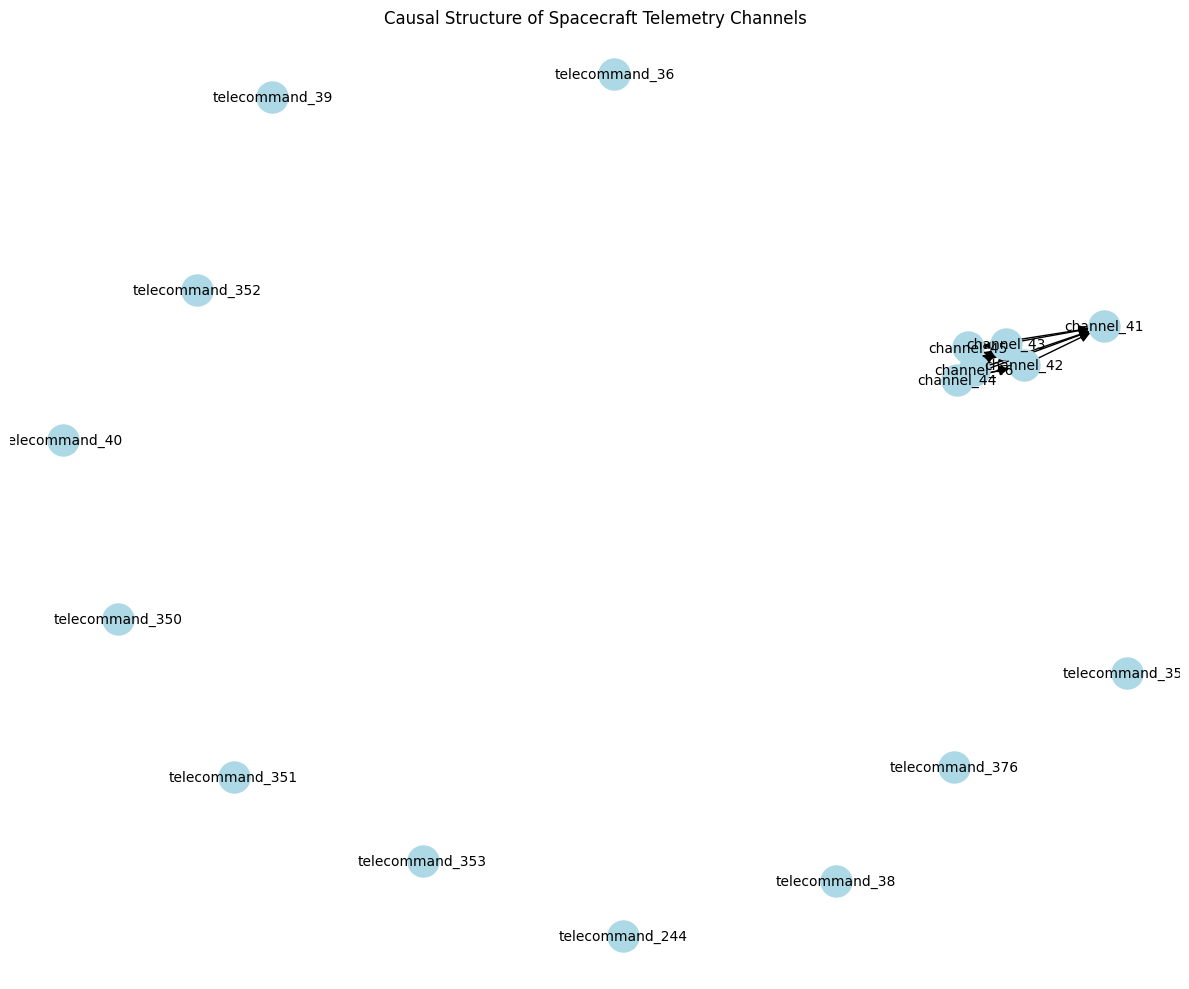

<ipython-input-12-2ab67d3b5484>:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  enhanced_df[feature_name].fillna(df[parent].iloc[0], inplace=True)
<ipython-input-12-2ab67d3b5484>:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Identified 629 mode change points
Detected 147173 anomalies (1.00% of data)
Too many anomalies to analyze (147173). Analyzing top 100 with highest scores.

Top 10 anomaly explanations:
Anomaly 1 at time index 9899749 (ID: 9899749):
  Root cause: channel_65
  Deviation: 35.5099
  Anomaly score: 0.2063
  Causal path: None

Anomaly 2 at time index 9899364 (ID: 9899364):
  Root cause: channel_65
  Deviation: 35.5099
  Anomaly score: 0.2085
  Causal path: None

Anomaly 3 at time index 9899316 (ID: 9899316):
  Root cause: channel_65
  Deviation: 35.5099
  Anomaly score: 0.2085
  Causal path: None

Anomaly 4 at time index 9899324 (ID: 9899324):
  Root cause: channel_65
  Deviation: 35.5099
  Anomaly score: 0.2085
  Causal path: None

Anomaly 5 at time index 9899323 (ID: 9899323):
  Root cause: channel_65
  Deviation: 35.5099
  Anomaly score: 0.2085
  Causal path: None

Anomaly 6 at time index 9899361 (ID: 9899361):
  Root cause: channel_65
  Deviation: 35.5099
  Anomaly score: 0.2085
  Causal

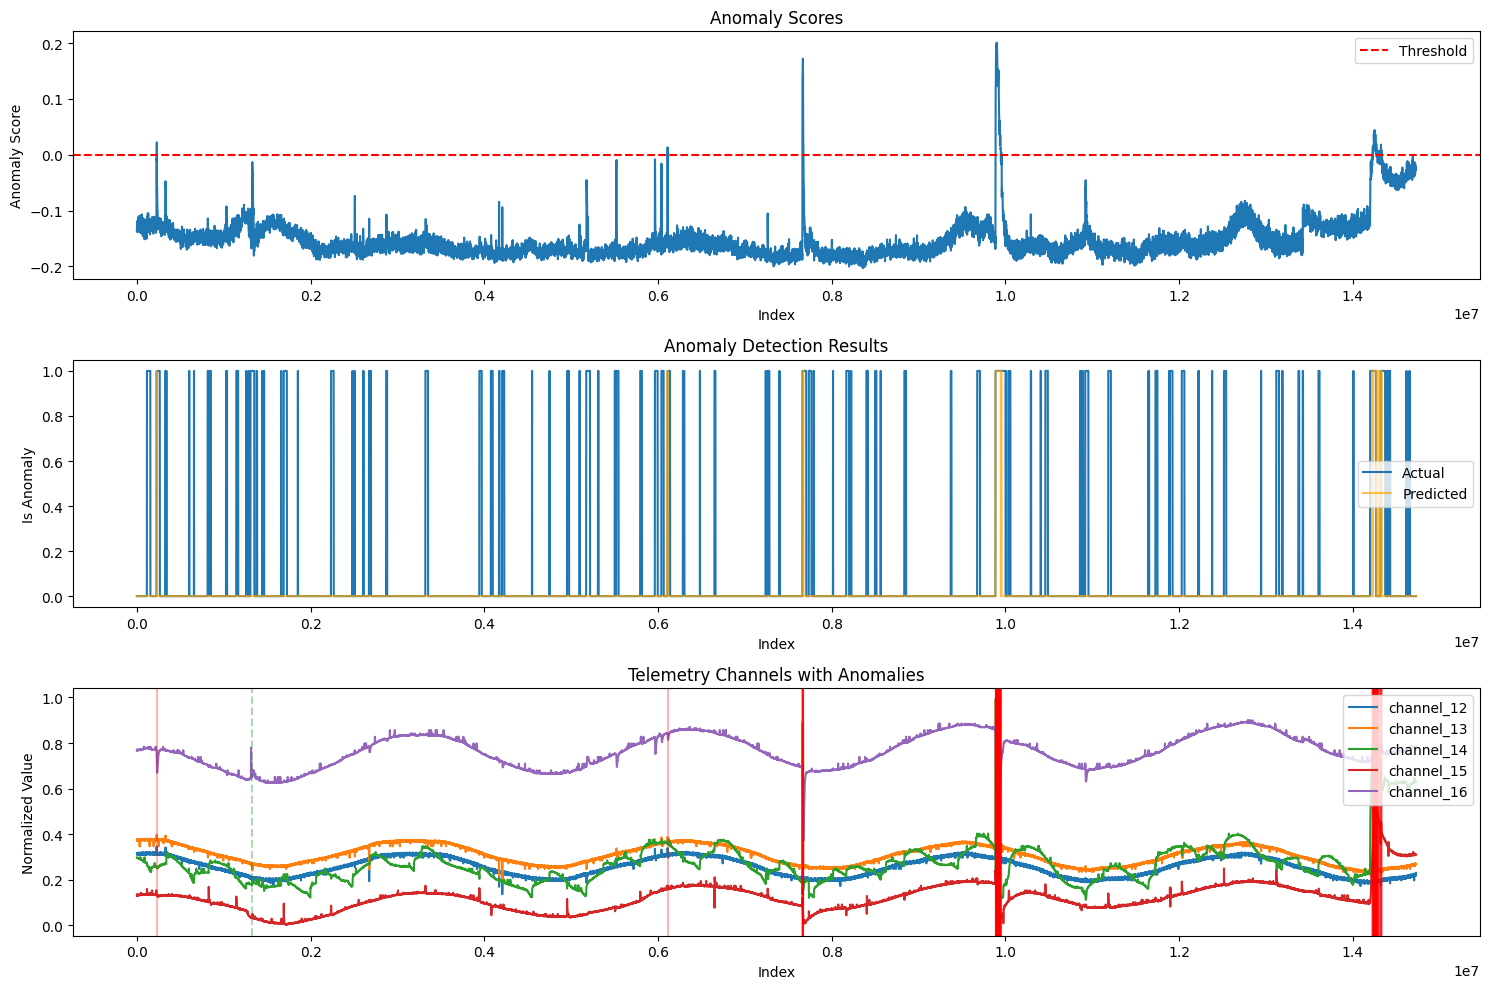

Evaluation metrics:
  Precision: 0.8330
  Recall: 0.0794
  F1: 0.1450
  F0.5: 0.2874


In [17]:
# Main Analysis Script - Run this cell to perform the analysis

# Set paths to data files
train_path = f"{esa_adb_challenge_path}/train.parquet"
target_channels_path = f"{esa_adb_challenge_path}/target_channels.csv"

# Define parameters
n_samples = 100000  # Number of samples to analyze (None for all)
contamination = 0.01  # Expected proportion of anomalies

# 1. Load and prepare data
df_train = load_data(train_path, n_samples = None)
df_train, target_channels, telecommand_cols, auxiliary_cols = prepare_data(df_train, target_channels_path)

# 2. Learn causal structure
causal_structure = learn_causal_structure(df_train, target_channels, telecommand_cols, sample_size=min(10000, len(df_train)))
visualize_causal_graph(causal_structure)

# 3. Add causal features
enhanced_df = add_causal_features(df_train, causal_structure)

# 4. Process telecommands
mode_changes = process_telecommands(df_train, telecommand_cols)

# 5. Detect anomalies using Isolation Forest
detector = IsolationForestDetector(contamination=contamination)
predictions, scores = detector.fit_detect(enhanced_df, target_channels, mode_changes)

# 6. Analyze and explain anomalies
anomaly_indices = np.where(predictions == 1)[0]
print(f"Detected {len(anomaly_indices)} anomalies ({len(anomaly_indices)/len(df_train)*100:.2f}% of data)")

explanations = analyze_anomalies(df_train, anomaly_indices, causal_structure, target_channels, scores)
print_explanations(explanations, max_count=10)

# 7. Visualize results
plot_detection_results(df_train, predictions, scores, target_channels, mode_changes)

# 8. Evaluate if ground truth is available
if 'is_anomaly' in df_train.columns:
    precision = precision_score(df_train['is_anomaly'].values, predictions, zero_division=0)
    recall = recall_score(df_train['is_anomaly'].values, predictions, zero_division=0)
    f1 = f1_score(df_train['is_anomaly'].values, predictions, zero_division=0)
    f0_5 = fbeta_score(df_train['is_anomaly'].values, predictions, beta=0.5, zero_division=0)

    print("Evaluation metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1: {f1:.4f}")
    print(f"  F0.5: {f0_5:.4f}")

## GENERATING SUBMISSION FILE

In [18]:
# Generate a submission file for the competition

def generate_submission(test_path, target_channels_path, sample_submission_path, output_path="submission.parquet"):
    """
    Generate submission file for the ESA-ADB challenge

    Args:
        test_path: Path to test data
        target_channels_path: Path to target channels list
        sample_submission_path: Path to sample submission file
        output_path: Path to write submission file
    """
    print("Loading test data...")
    df_test = load_data(test_path)
    df_test, target_channels, telecommand_cols, auxiliary_cols = prepare_data(df_test, target_channels_path)

    print("Learning causal structure...")
    causal_structure = learn_causal_structure(df_test, target_channels, telecommand_cols,
                                              sample_size=min(10000, len(df_test)))

    print("Adding causal features...")
    enhanced_df = add_causal_features(df_test, causal_structure)

    print("Processing telecommands...")
    mode_changes = process_telecommands(df_test, telecommand_cols)

    print("Detecting anomalies...")
    detector = IsolationForestDetector(contamination=0.01)
    predictions, scores = detector.fit_detect(enhanced_df, target_channels, mode_changes)

    # Create submission dataframe
    print("Creating submission file...")
    submission = pd.DataFrame({
        'id': df_test['id'].values,
        'is_anomaly': predictions
    })

    # Save submission file
    submission.to_parquet(output_path)
    print(f"Submission file saved to {output_path}")
    print(f"Total anomalies predicted: {submission['is_anomaly'].sum()} ({submission['is_anomaly'].mean()*100:.2f}%)")

    return submission

# Paths to test data files - set these to match your Colab environment
test_path = f"{esa_adb_challenge_path}/test.parquet"
target_channels_path = f"{esa_adb_challenge_path}/target_channels.csv"
sample_submission_path = "/content/sample_submission.parquet"

# Run this cell to generate a submission
# Uncomment the next line when you're ready to generate a submission
submission = generate_submission(test_path, target_channels_path, sample_submission_path)

Loading test data...
Loading data from /root/.cache/kagglehub/competitions/esa-adb-challenge/test.parquet...
Loaded data with shape: (521280, 88)
Target channels: 58
Telecommand channels: 11
Auxiliary channels: 18
Learning causal structure...
Learning causal structure...


  0%|          | 0/5 [00:00<?, ?it/s]

Learned structure with 30 edges
Adding causal features...
Processing telecommands...


<ipython-input-12-2ab67d3b5484>:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  enhanced_df[feature_name].fillna(df[parent].iloc[0], inplace=True)
<ipython-input-12-2ab67d3b5484>:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Identified 10 mode change points
Detecting anomalies...
Creating submission file...
Submission file saved to submission.parquet
Total anomalies predicted: 5213 (1.00%)


## PARAMETER FINE TUNING

Testing contamination = 0.001
  Anomalies found: 14565 (0.10%)
  Precision: 1.0000
  Recall: 0.0094
  F1: 0.0187
  F0.5: 0.0454

Testing contamination = 0.005
  Anomalies found: 73642 (0.50%)
  Precision: 0.9975
  Recall: 0.0476
  F1: 0.0908
  F0.5: 0.1998

Testing contamination = 0.01
  Anomalies found: 147283 (1.00%)
  Precision: 0.8331
  Recall: 0.0795
  F1: 0.1451
  F0.5: 0.2876

Testing contamination = 0.02
  Anomalies found: 294567 (2.00%)
  Precision: 0.6424
  Recall: 0.1225
  F1: 0.2058
  F0.5: 0.3475

Testing contamination = 0.05
  Anomalies found: 736416 (5.00%)
  Precision: 0.4254
  Recall: 0.2029
  F1: 0.2747
  F0.5: 0.3489



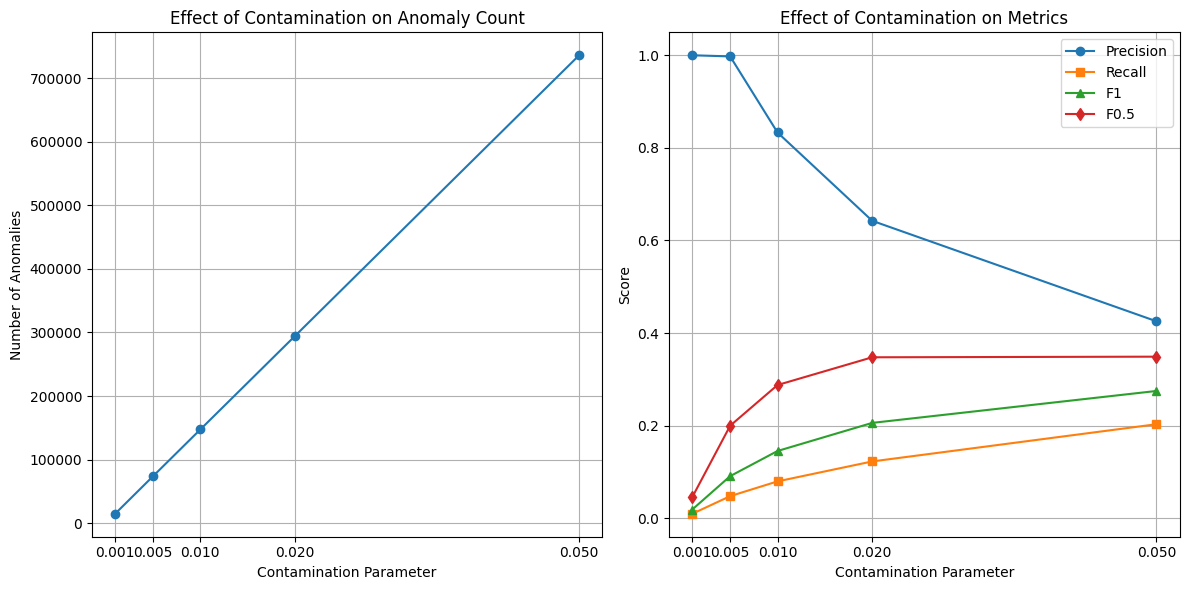

In [20]:
# Parameter Tuning for Isolation Forest

def tune_contamination(df, target_channels, contamination_values=[0.001, 0.005, 0.01, 0.02, 0.05]):
    """
    Try different contamination values and see their impact on anomaly detection

    Args:
        df: DataFrame with telemetry data
        target_channels: List of target channel names
        contamination_values: List of contamination values to try
    """
    results = []

    for contamination in contamination_values:
        print(f"Testing contamination = {contamination}")

        # Run anomaly detection
        detector = IsolationForestDetector(contamination=contamination)
        predictions, scores = detector.fit_detect(df, target_channels)

        # Calculate metrics if ground truth is available
        metrics = {}
        if 'is_anomaly' in df.columns:
            metrics['precision'] = precision_score(df['is_anomaly'].values, predictions, zero_division=0)
            metrics['recall'] = recall_score(df['is_anomaly'].values, predictions, zero_division=0)
            metrics['f1'] = f1_score(df['is_anomaly'].values, predictions, zero_division=0)
            metrics['f0.5'] = fbeta_score(df['is_anomaly'].values, predictions, beta=0.5, zero_division=0)

        # Record results
        result = {
            'contamination': contamination,
            'anomalies_found': predictions.sum(),
            'percentage': predictions.mean() * 100,
            'metrics': metrics
        }
        results.append(result)

        print(f"  Anomalies found: {result['anomalies_found']} ({result['percentage']:.2f}%)")
        if metrics:
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1: {metrics['f1']:.4f}")
            print(f"  F0.5: {metrics['f0.5']:.4f}")
        print()

    # Plot results
    plt.figure(figsize=(12, 6))

    # Plot anomaly counts
    plt.subplot(1, 2, 1)
    contaminations = [r['contamination'] for r in results]
    counts = [r['anomalies_found'] for r in results]
    percentages = [r['percentage'] for r in results]

    plt.plot(contaminations, counts, 'o-')
    plt.xlabel('Contamination Parameter')
    plt.ylabel('Number of Anomalies')
    plt.title('Effect of Contamination on Anomaly Count')
    plt.xticks(contaminations)
    plt.grid(True)

    # Plot metrics if available
    if 'is_anomaly' in df.columns:
        plt.subplot(1, 2, 2)
        precisions = [r['metrics']['precision'] for r in results]
        recalls = [r['metrics']['recall'] for r in results]
        f1s = [r['metrics']['f1'] for r in results]
        f05s = [r['metrics']['f0.5'] for r in results]

        plt.plot(contaminations, precisions, 'o-', label='Precision')
        plt.plot(contaminations, recalls, 's-', label='Recall')
        plt.plot(contaminations, f1s, '^-', label='F1')
        plt.plot(contaminations, f05s, 'd-', label='F0.5')
        plt.xlabel('Contamination Parameter')
        plt.ylabel('Score')
        plt.title('Effect of Contamination on Metrics')
        plt.xticks(contaminations)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return results

# Uncomment the next line to run parameter tuning
tuning_results = tune_contamination(df_train, target_channels)